# How to implement NN in DyNet
Original source: Yoav Goldberg talk on Pycon Israel 2017 (https://youtu.be/8eYZz6kiuUA)

## Computation Graphs
Example network: MLP (Multi-Layer Perceptron)<br/>
Two linear layers + tanh function, which can be expressed as a graph:
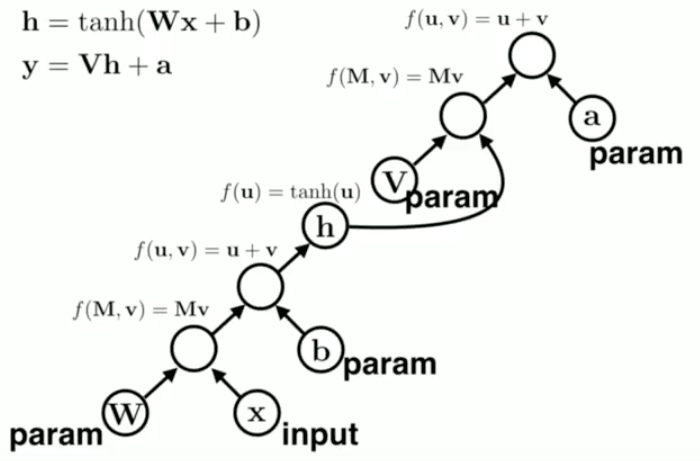
<br/>
### Training a Neural Network
Once we have this graph, we can **train** it: run **forward** to get values, and **backward** to get gradients.

## The Python NN toolkits
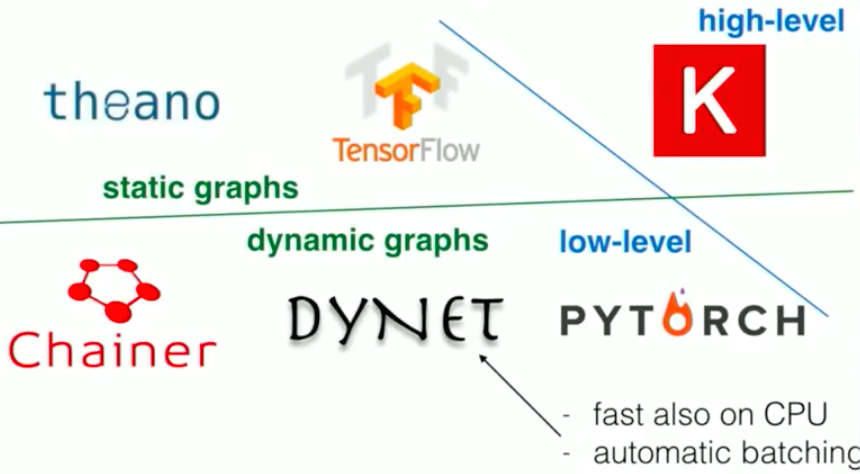

### Static frameworks (TF, Theano)
- Use a DSL (Domain Specific Language) for defining the graph
- Feed examples through the graph

### Dynamic Frameworks (DyNet, PyTorch)
- Use Python for creating the graph
- Build a graph for each example
    - Crucial when different examples have different structures, i.e. RNN where every sequence has different length
    - In TF and other frameworks we'd have to use workaraounds, like padding

### DyNet
- c++ code
- **Python wrapper**

## Buidling Computation Graphs in DyNet

### The major players
- **Computation Graph**. The graph itself. Implicit. Singleton
- **Expressions**. Nodes in the graph
- **Parameters**. The thing we are optimizing over ;)
    - vectors, matrices
    - they **out-live** the computation graph: when we create a new graph, everything dies but the parameters persist
- **Model**. A collection of parameters
- **Trainer**. Updates the parameters according to the gradients and some rules
    - SGD, Adam, ...

### Expressions

In [ ]:
import dynet as dy

# create a new computation graph
dy.renew_cg()

# create expressions and combine them with operators
# v1...v6 are nodes in the graph; they represent simbolic computations (they don't actually compute anything)
v1 = dy.inputVector([1, 2, 3, 4])
v2 = dy.inputVector([5, 6, 7, 8])
v3 = v1 + v2
v4 = v3 * 2
v5 = v1 + 1
v6 = dy.concatenate([v1, v2, v3, v5])

# v1 ... v6 are expression objects
print(v6)
    

In [ ]:
# forward computation: get the actual value of the computation
# we can use: .value(), .npvalue(), .scalar_value(), .vec_value(), .forward()
print(v6.value())
print(v6.npvalue())
# print(v6.scalar_value())
print(v6.vec_value())
print(v6.forward())  # if we don't need the result, i.e., we are training

### Model and Parameters

In [ ]:
model = dy.Model()

W = model.add_parameters((20, 4))
b = model.add_parameters(20)

dy.renew_cg()

x = dy.inputVector([1, 2, 3, 4])

# combine expressions to create another expression
y = W * x + b

print (y.value())

### Parameters Initialization

In [ ]:
import numpy as np
model = dy.Model()

pW = model.add_parameters((4, 4))
pW2 = model.add_parameters((4, 4), init=dy.GlorotInitializer())
pW3 = model.add_parameters((4, 4), init=dy.NormalInitializer(0, 1))
pW4 = model.parameters_from_numpy(np.eye(4))

In [ ]:
print(pW.value())
print(pW2.value())
print(pW3.value())
print(pW4.value())

### Trainers and Backdrop

- Initialize a **Trainer** with a given model
    - there are different trainers: SimpleSGDTrainer, MomentumSGDTrainer, AdagradTrainer, **AdamTrainer**...
- Compute **gradients** by calling _expr.backward()_ from a scalar node
- **update the model parameters** using the gradients calling _Trainer.update()_

Silly example: we want to minimize the dot product

In [ ]:
# create model, add parameters and create Trainer
model = dy.Model()
v = model.add_parameters(10)
trainer = dy.SimpleSGDTrainer(model)

# This loop will optimize v such that its dot product with itself will be low
# For each training example:
#    - create computation graph
#    - run forward (compute the loss)
#    - run backward (compute the gradients)
#    - update parameters
for i in range(10):
    dy.renew_cg()
    # DEPRECATED. There is no longer need to explicitly add parameters to the computation graph. 
    # Any used parameter will be added automatically.
    # v = dy.parameter(p_v)
    v2 = dy.dot_product(v, v)

    v2.forward()
    v2.backward()

    trainer.update()
    
    # check value of dot product to see that it decreases with each iteration
    print(dy.dot_product(v, v).value())

### Example: MLP for XOR Problem
Linear models can not model the XOR problem, but NN can!

We model it as the sigmoid over the MLP, and this is the mathematical notation:
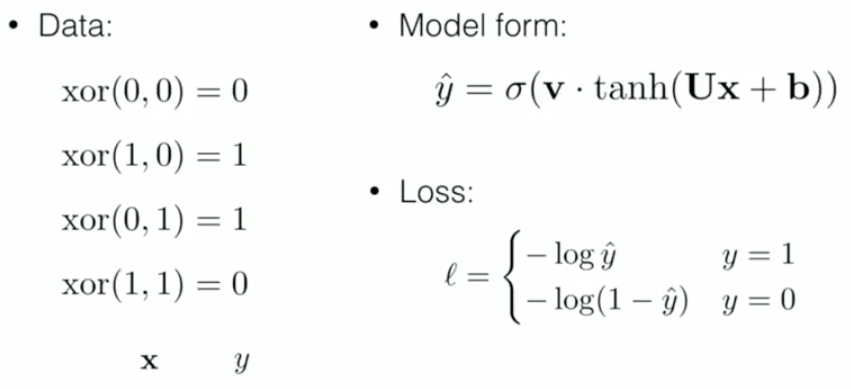

In [8]:
import dynet as dy
import random

data = [([0, 1], 1),
        ([1, 0], 1),
        ([0, 0], 0),
        ([1, 1], 0)]

model = dy.Model()
U = model.add_parameters((4, 2))
b = model.add_parameters(4)
v = model.add_parameters(4)

trainer = dy.SimpleSGDTrainer(model)
closs = 0.0

for iter in range(1000):
    random.shuffle(data)
    for x, y in data:
        dy.renew_cg()

        yhat = dy.logistic(dy.dot_product(v.value(), dy.tanh(U.value() * x + b.value())))

        if y == 0:
            loss = -dy.log(1 - yhat)
        elif Y == 1:
            loss = -dy.log(yhat)

        closs += loss.scalar_value()  # forward
        loss.backward()
        trainer.update()

        if iter > 0 and iter % 100 == 0:
            print('Iter: ', iter, 'loss: ', closs/400)
            closs = 0


ValueError: operands could not be broadcast together with shapes (4,2) (4,) 